In [296]:
import pandas as pd
from pandas import json_normalize
import json
import matplotlib.pyplot as plt
import requests
from requests.auth import HTTPBasicAuth

In [297]:
#initializing page variable
page=1
sales_data=[]
while(1):
    # api get request for sales in the month of January
    response = requests.get('https://api.cin7.com/api/v1/SalesOrders?rows=250&where= createdDate<2023-02-01T00:00:00Z and createdDate>2022-12-31T23:59:59Z&fields=createdDate,lineItems&page='+str(page),auth = HTTPBasicAuth('DiggsIncUS', '9901f725991a42c4b8ea12917e3c21d9'))
    #looping the api call till there isn't an empty object is returned
    if not response.json():
        break
    sales_data += response.json()
    #increasing the page value to iterate through all pages and get the data
    page += 1                     

In [299]:
#converting the json object to a dataframe
df = pd.json_normalize(sales_data)
#print(df)

               createdDate                                          lineItems
0     2023-01-31T23:57:15Z  [{'id': 173662, 'createdDate': '2023-01-31T23:...
1     2023-01-31T23:56:06Z  [{'id': 173664, 'createdDate': '2023-01-31T23:...
2     2023-01-31T23:48:27Z  [{'id': 173681, 'createdDate': '2023-01-31T23:...
3     2023-01-31T23:46:24Z  [{'id': 173660, 'createdDate': '2023-01-31T23:...
4     2023-01-31T23:34:35Z  [{'id': 173659, 'createdDate': '2023-01-31T23:...
...                    ...                                                ...
4207  2023-01-01T01:01:00Z  [{'id': 162093, 'createdDate': '2023-01-01T01:...
4208  2023-01-01T00:18:21Z  [{'id': 161446, 'createdDate': '2023-01-01T00:...
4209  2023-01-01T00:07:18Z  [{'id': 161442, 'createdDate': '2023-01-01T00:...
4210  2023-01-01T00:05:43Z  [{'id': 161444, 'createdDate': '2023-01-01T00:...
4211  2023-01-01T00:01:22Z  [{'id': 161439, 'createdDate': '2023-01-01T00:...

[4212 rows x 2 columns]


In [300]:
#separating objects from the listItems column each object forming a separate row
df=df.explode('lineItems').reset_index(drop=True)
#print(df)

                createdDate                                          lineItems
0      2023-01-31T23:57:15Z  {'id': 173662, 'createdDate': '2023-01-31T23:5...
1      2023-01-31T23:56:06Z  {'id': 173664, 'createdDate': '2023-01-31T23:5...
2      2023-01-31T23:56:06Z  {'id': 173665, 'createdDate': '2023-01-31T23:5...
3      2023-01-31T23:56:06Z  {'id': 173666, 'createdDate': '2023-01-31T23:5...
4      2023-01-31T23:56:06Z  {'id': 173667, 'createdDate': '2023-01-31T23:5...
...                     ...                                                ...
10182  2023-01-01T00:05:43Z  {'id': 161445, 'createdDate': '2023-01-01T00:0...
10183  2023-01-01T00:05:43Z  {'id': 161443, 'createdDate': '2023-01-01T00:0...
10184  2023-01-01T00:01:22Z  {'id': 161439, 'createdDate': '2023-01-01T00:0...
10185  2023-01-01T00:01:22Z  {'id': 161441, 'createdDate': '2023-01-01T00:0...
10186  2023-01-01T00:01:22Z  {'id': 161440, 'createdDate': '2023-01-01T00:0...

[10187 rows x 2 columns]


In [301]:
#dropping all nan values and resetting the index
df=df.dropna().reset_index(drop=True)

In [302]:
#adding code and qty columns to the dataframe by accessing it from the linItems column and then filtering dataframe to show only those columns
df['code']=''
df['qty']=''
for i in range(len(df)):
    df.loc[i, "code"]=df.loc[i, "lineItems"]['code']
    df.loc[i, "qty"]=int(df.loc[i, "lineItems"]['qty'])
    
df=df.filter(['code','qty'], axis=1)
#df

,code,qty
0,TRV001AOSG,1
1,PAD018AALG,1
2,GRO010AASIR,1
3,CRA022AALW-1,1
4,CRA022AALW-2,1
...,...,...
9810,CRA022AALW-2,1
9811,CRA022AALW,1
9812,CRA002AAMG,1
9813,PAD020AAMG,1


In [303]:
#accessing the skumapping excel
compare_df=pd.read_excel('/Users/nidhimenon/Downloads/DiggsSKUMapping.xlsx')
compare_df=compare_df.filter(['Diggs SKU', 'Product Variant'])
compare_df=compare_df.rename(columns={'Diggs SKU':'code'})
#compare_df

,code,Product Variant
0,WSC007AALW,CollarLarge Ash
1,WSC012AALP,CollarLarge Blush
2,WSC040AALP,CollarLarge Blush
3,WSC008AALB,CollarLarge Charcoal
4,WSC016AALL,CollarLarge Lilac
...,...,...
218,PAD008AAMT,V1 SnoozMedium Tan
219,PAD002AASB,V1 SnoozSmall Dark Grey
220,PAD005AASC,V1 SnoozSmall Dark Grey
221,PAD001AASG,V1 SnoozSmall Light Grey


In [304]:
#matching the data from sales to the skumapping excel sheet to get product variants and their quantity sold
final_df=pd.merge(df, compare_df, on='code', how='left')
#final_df.to_excel("/Users/nidhimenon/Desktop/output_nan.xlsx")
final_df=final_df.groupby("Product Variant")["qty"].sum()
final_df=final_df.sort_values(ascending=False)
#print(final_df)

Product Variant
Poop Bags                  977
Groov Turquoise            868
Spreadable                 800
Bowl ClipCharcoal          612
Groov Blush                583
                          ... 
HarnessSmall Grey            1
HarnessExtra Small Grey      1
RevolMedium Pine             1
CollarLarge Slate            1
CollarLarge Charcoal         1
Name: qty, Length: 117, dtype: int64


In [305]:
#saving it to excel sheet
final_df.to_excel("/Users/nidhimenon/Desktop/output.xlsx")

In [306]:
#displaying top 5 most sold products
data=final_df.head(5)
data

Product Variant
Poop Bags            977
Groov Turquoise      868
Spreadable           800
Bowl ClipCharcoal    612
Groov Blush          583
Name: qty, dtype: int64

<AxesSubplot:xlabel='Product Variant'>

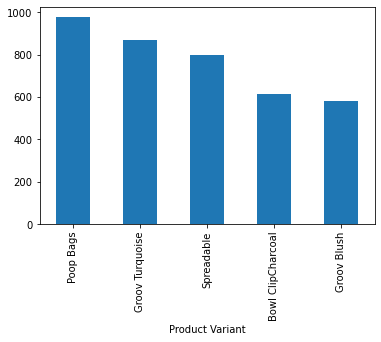

In [307]:
data.plot.bar()	

In [326]:
data2=final_df.tail(5)
print(data2)

Product Variant
HarnessSmall Grey          1
HarnessExtra Small Grey    1
RevolMedium Pine           1
CollarLarge Slate          1
CollarLarge Charcoal       1
Name: qty, dtype: int64


<AxesSubplot:xlabel='Product Variant'>

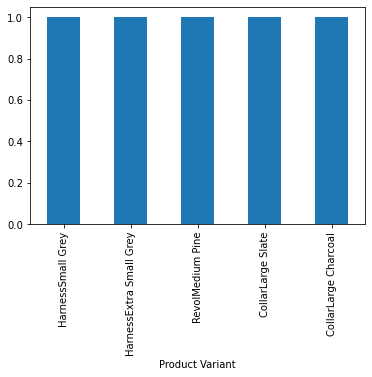

In [327]:
data2.plot.bar()

In [335]:
products_list=compare_df["Product Variant"]
products_list

0               CollarLarge Ash
1             CollarLarge Blush
2             CollarLarge Blush
3          CollarLarge Charcoal
4             CollarLarge Lilac
                 ...           
218          V1 SnoozMedium Tan
219     V1 SnoozSmall Dark Grey
220     V1 SnoozSmall Dark Grey
221    V1 SnoozSmall Light Grey
222           V1 SnoozSmall Tan
Name: Product Variant, Length: 223, dtype: object

In [336]:
products_list.drop_duplicates().reset_index(drop=True)

0                CollarLarge Ash
1              CollarLarge Blush
2           CollarLarge Charcoal
3              CollarLarge Lilac
4               CollarLarge Navy
                 ...            
126    V1 SnoozMedium Light Grey
127           V1 SnoozMedium Tan
128      V1 SnoozSmall Dark Grey
129     V1 SnoozSmall Light Grey
130            V1 SnoozSmall Tan
Name: Product Variant, Length: 131, dtype: object

In [337]:
no_purchase=pd.merge(final_df, products_list, on='Product Variant', how='right')

In [338]:
no_purchase

,Product Variant,qty
0,CollarLarge Ash,5.0
1,CollarLarge Blush,2.0
2,CollarLarge Blush,2.0
3,CollarLarge Charcoal,1.0
4,CollarLarge Lilac,4.0
...,...,...
218,V1 SnoozMedium Tan,5.0
219,V1 SnoozSmall Dark Grey,2.0
220,V1 SnoozSmall Dark Grey,2.0
221,V1 SnoozSmall Light Grey,55.0


In [345]:
no_purchase=no_purchase[no_purchase['qty'].isnull()]
print(no_purchase)

                      Product Variant  qty
36       Bowl + Crate ClipI/LCharcoal  NaN
37       Bowl + Crate ClipI/LCharcoal  NaN
40       Bowl + Crate ClipS/MCharcoal  NaN
41       Bowl + Crate ClipS/MCharcoal  NaN
85                 HarnessMedium Grey  NaN
127                   Passenger Slate  NaN
138       Refurbished RevolMedium Ash  NaN
139  Refurbished RevolMedium Charcoal  NaN
141      Refurbished RevolMedium Pine  NaN
186              Revol/SnoozLarge Ash  NaN
187              Revol/SnoozLarge Ash  NaN
188              Revol/SnoozLarge Ash  NaN
189              Revol/SnoozLarge Ash  NaN
190              Revol/SnoozLarge Ash  NaN
191              Revol/SnoozLarge Ash  NaN
192         Revol/SnoozLarge Charcoal  NaN
193             Revol/SnoozLarge Grey  NaN
194             Revol/SnoozMedium Ash  NaN
195        Revol/SnoozMedium Charcoal  NaN
196            Revol/SnoozMedium Grey  NaN
222                 V1 SnoozSmall Tan  NaN
